# Week 2: Keyword search using dynamic time warping
This week we're going to 

In [33]:
import os
from glob import glob
import pandas as pd
import librosa
from librikws import *
import numpy as np
from tslearn.metrics import dtw_path, dtw
from scipy.spatial.distance import cdist
from praatio import textgrid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib widget



## Section 1: Comparing sequences with Dynamic Time Warping

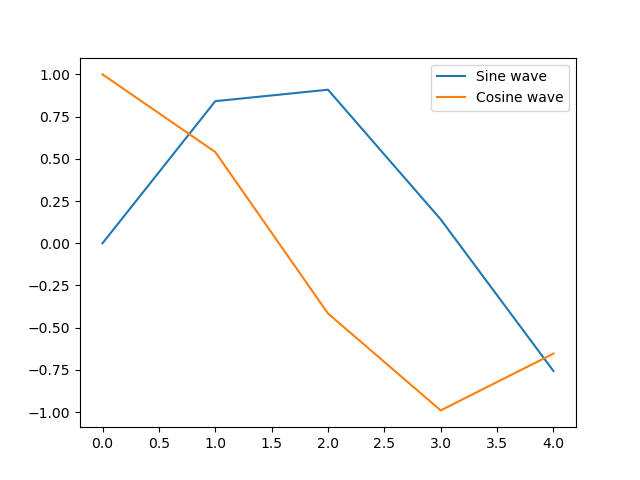

In [2]:
A = np.sin(np.arange(0,5))
B = np.cos(np.arange(0,5))
fig, ax = plt.subplots()
ax.plot(A, label='Sine wave')
ax.plot(B, label='Cosine wave')
ax.legend()
plt.show()

In [3]:
def get_dtw_axes():
    fig = plt.figure(figsize=(5, 5))
    
    # definitions for the axes
    left, bottom = 0.01, 0.1
    w_ts = h_ts = 0.2
    left_h = left + w_ts + 0.02
    width = height = 0.65
    bottom_h = bottom + height + 0.02
    
    top_rectangle = [left, bottom, w_ts, height]
    center_rectangle = [left_h, bottom, width, height]
    left_rectangle = [left_h, bottom_h, width, h_ts]
    
    top_axes = plt.axes(top_rectangle)
    center_axes = plt.axes(center_rectangle)
    left_axes = plt.axes(left_rectangle)

    return top_axes, center_axes, left_axes

def plot_dtw(seq_a, seq_b, distance_matrix, path=None):
    top, center, left = get_dtw_axes()
    center.imshow(distance_matrix, origin='lower')
    center.axis("off")
    center.autoscale(False)
    if path:
        center.plot(
            [j for (i, j) in path],
            [i for (i, j) in path],
            "w-",
            linewidth=3.
        )
    
    left.plot(np.arange(seq_a.shape[0]), seq_a, "b-", linewidth=3.)
    left.axis("off")
    left.set_xlim((0, seq_a.shape[0] - 1))
    
    top.plot(-seq_b, np.arange(seq_b.shape[0]), "g-", linewidth=3.)
    top.axis("off")
    top.set_ylim((0, seq_b.shape[0] - 1))
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_3048919/3602118050.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


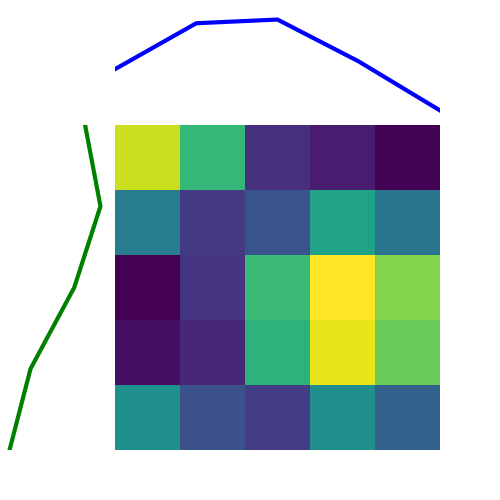

In [4]:
mat = cdist(A[:,np.newaxis], B[:,np.newaxis])
plot_dtw(A, B, mat)

/tmp/ipykernel_3048919/3602118050.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


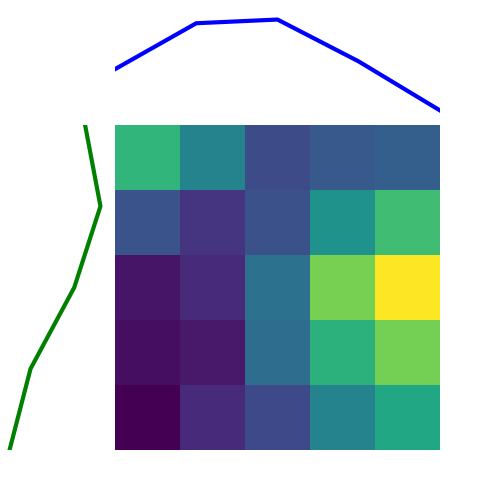

In [22]:
dtw_matrix = np.full((A.shape[0]+1,B.shape[0]+1), np.inf)
dtw_matrix[0,0]=0

for i, a_i in enumerate(A, start=1):
    for j, b_j in enumerate(B, start=1):
        current_distance = np.abs(a_i-b_j)
        
        left = dtw_matrix[i,j-1]
        bottom = dtw_matrix[i-1,j]
        diag = dtw_matrix[i-1,j-1]

        prev_distance = min(left, bottom, diag)

        dtw_matrix[i,j] = current_distance + prev_distance
        
plot_dtw(A, B, dtw_matrix[1:,1:])

## Section 2: Encoding audio with MFCCs

In [6]:
keywords = get_unique_keywords()

In [23]:
keyword, sentence = get_random_keyword_sentence_pair(keywords[42])
keyword

word_index                                                    1197
index                                                         1197
file             train-clean-100/1970/26100/1970-26100-0007_2wo...
speaker                                                       1970
keyword                                                    i asked
dur                                                            0.7
class                                                            2
sentence_file      train-clean-100/1970/26100/1970-26100-0007.flac
Name: 1197, dtype: object

In [8]:
sentence

sentence_index                                                13180
speaker                                                        3947
chapter                                                       13260
file                train-clean-100/3947/13260/3947-13260-0045.flac
sentence          that day she was here when you talked about he...
Name: 13180, dtype: object

In [9]:
get_librispeech_path = lambda relpath: os.path.join(LIBRISPEECH_ROOT, relpath)

In [10]:
textgrid_path = sentence['file'].replace('.flac', '.TextGrid')

In [38]:
def textgrid_to_df(textgrid_path):
    absolute_path = os.path.join(LIBRISPEECH_ROOT, textgrid_path)
    textgrid_obj = textgrid.openTextgrid(absolute_path, includeEmptyIntervals=True)
    rows = []
    for tier in textgrid_obj.tiers:
        for start, end, value in tier.entries:
            if not value:
                continue
            rows.append({'start': start, 'end': end, 'value': value, 'tier': tier.name})
    df = pd.DataFrame(rows)
    return df

In [39]:
textgrid_df = textgrid_to_df(textgrid_path)
textgrid_df

,start,end,value,tier
0,0.36,0.62,that,words
1,0.62,0.80,day,words
2,0.80,0.99,she,words
3,0.99,1.17,was,words
4,1.17,1.52,here,words
...,...,...,...,...
219,15.03,15.10,IY0,phones
220,15.10,15.17,N,phones
221,15.17,15.37,AH1,phones
222,15.37,15.53,F,phones


In [ ]:
df['start_sample'] = (df['start']*samplerate).astype(int)
df['end_sample'] = (df['end']*samplerate).astype(int)
df.head()

In [ ]:
phonemes = list(df.loc[df['tier']=='phones', 'value'].unique())
phonemes

In [ ]:
mfcc_matrix = librosa.feature.mfcc(y=wav, sr=samplerate, n_mfcc=13)
mfcc_matrix.shape

In [ ]:
mfcc_window_count = mfcc_matrix.shape[1]
num_samples = wav.shape[0]
samples_per_mfcc_window = num_samples//mfcc_window_count
samples_per_mfcc_window

In [ ]:
df['mfcc_index_start']=df['start_sample']//samples_per_mfcc_window
df['mfcc_index_end']=df['end_sample']//samples_per_mfcc_window-1

df.head()

In [ ]:
mfcc_phoneme_ids = np.zeros(mfcc_window_count, dtype=int)

def set_mfcc_phoneme_ids(row):
    mfcc_phoneme_ids[row['mfcc_index_start']:row['mfcc_index_end']]=phonemes.index(row['value'])

df[df['tier']=='phones'].apply(set_mfcc_phoneme_ids, axis=1)
mfcc_phoneme_ids

Let's visualize the MFCCs using `t-SNE`

In [ ]:
mfcc_tsne = sklearn.manifold.TSNE().fit_transform(mfcc_matrix.T)
mfcc_tsne.shape

In [ ]:
tsne_df = pd.DataFrame(mfcc_tsne)
tsne_df['phoneme']=mfcc_phoneme_ids
tsne_df['phoneme']=tsne_df['phoneme'].apply(lambda i: phonemes[i])
tsne_df.head()

In [ ]:
speech_mask = tsne_df['phoneme']!='sil'

In [ ]:
sns.scatterplot(tsne_df[speech_mask], x=0, y=1, hue='phoneme')